<a href="https://colab.research.google.com/github/mohamedghaly1/ECG-Detection-Using-EGRU/blob/main/LSTM%20and%20GRU%20models/Copy_of_LSTM_GRU_model_ECG_ARRHYHMIA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Setup**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
os.environ['KAGGLE_CONFIG_DIR']='/content/gdrive/MyDrive/kaggle_dataset'

In [ ]:
%cd /content/gdrive/MyDrive/kaggle_dataset/

/content/gdrive/MyDrive/kaggle_dataset


In [ ]:
!ls

best_model.h5  heartbeat  kaggle.json


In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat

 92% 91.0M/98.8M [00:00<00:00, 119MB/s]
100% 98.8M/98.8M [00:00<00:00, 113MB/s]


In [ ]:
!mkdir heartbeat
!mv heartbeat.zip heartbeat

mkdir: cannot create directory ‘heartbeat’: File exists


In [ ]:
%cd heartbeat/

/content/gdrive/MyDrive/kaggle_dataset/heartbeat


In [ ]:
!unzip heartbeat.zip

Archive:  heartbeat.zip
replace mitbih_test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
!pip install flopth

In [ ]:
!flopth -m alexnet

+---------------+-------------------+-------------+-------------+--------------------------------+----------+------------------+--------------------------------+----------+-----------------+---------------------+
| module_name   | module_type       | in_shape    | out_shape   | kernel_size,padding,stride     | params   | params_percent   | params_percent_vis             | flops    | flops_percent   | flops_percent_vis   |
+===============+===================+=============+=============+================================+==========+==================+================================+==========+=================+=====================+
| features.0    | Conv2d            | (3,224,224) | (64,55,55)  | k=(11, 11), p=(2, 2), s=(4, 4) | 23.296K  | 0.0381271%       |                                | 70.4704M | 9.84839%        | ####                |
+---------------+-------------------+-------------+-------------+--------------------------------+----------+------------------+--------------------

**Importing libraries and reading dataset**

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from flopth import flopth
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from sklearn.utils import class_weight
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import LSTM, GRU, Dense, Input, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
train_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_train.csv",header=None)
test_df = pd.read_csv("/content/gdrive/MyDrive/kaggle_dataset/heartbeat/mitbih_test.csv",header=None)
print(train_df[187].value_counts())

## **Model 1 (using LSTM)**

**Sampling**

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

**Oversampling / SMOTE Sampling**

In [ ]:
# from sklearn.utils import resample
# df_1=train_df [train_df [187]==1]
# df_2=train_df [train_df [187]==2]
# df_3=train_df [train_df[187]==3]
# df_4=train_df [train_df[187]==4]
# df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)
# df_1_upsample=resample(df_1,replace=True,n_samples=20000,random_state=123)
# df_2_upsample=resample(df_2,replace=True,n_samples=20000,random_state=124)
# df_3_upsample=resample(df_3,replace=True,n_samples=20000, random_state=125)
# df_4_upsample=resample (df_4, replace=True,n_samples=20000, random_state=126)
# train_df=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

# per_class = train_df[187].value_counts()
# plt.figure(figsize=(20,10))
# my_circle=plt.Circle( (0,0), 0.7, color='white')
# plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
# p=plt.gcf()
# p.gca().add_artist(my_circle)
# plt.show()

# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

**Plotting**

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

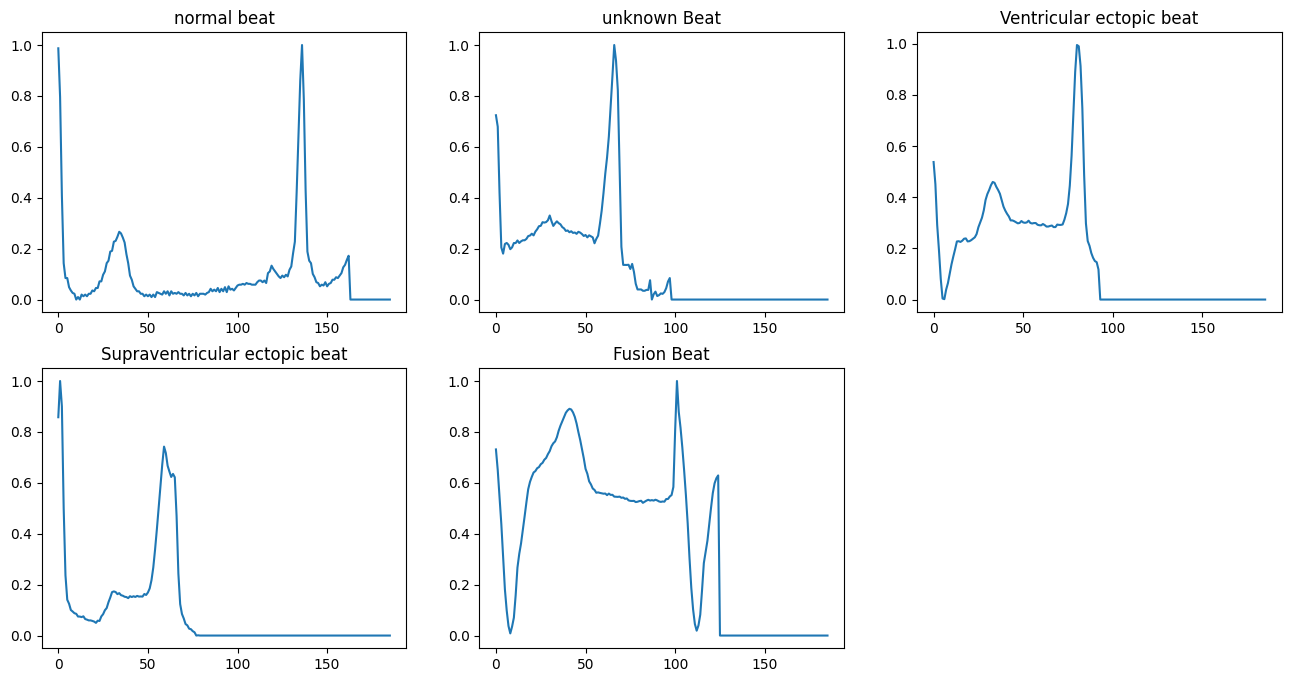

In [ ]:
plt.figure(figsize=(16,8))
# normal
plt.subplot(2, 3, 1)
plt.plot(classes.iloc[0,:186])
plt.title('normal beat')
# unknown
plt.subplot(2, 3, 2)
plt.plot(classes.iloc[1,:186])
plt.title('unknown Beat')
# veb
plt.subplot(2, 3, 3)
plt.plot(classes.iloc[2,:186])
plt.title('Ventricular ectopic beat')
# seb
plt.subplot(2, 3, 4)
plt.plot(classes.iloc[3,:186])
plt.title('Supraventricular ectopic beat')
# fusion
plt.subplot(2, 3, 5)
plt.plot(classes.iloc[4,:186])
plt.title('Fusion Beat')
# show plot
plt.show()

LSTM Network

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
def lstm_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_lstm = Input(shape=(im_shape), name='inputs_lstm')
    lstm1 = LSTM(64, return_sequences=True)(inputs_lstm)
    lstm1 = BatchNormalization()(lstm1)
    lstm2 = LSTM(64, return_sequences=True)(lstm1)
    lstm2 = BatchNormalization()(lstm2)
    lstm3 = LSTM(64)(lstm2)
    lstm3 = BatchNormalization()(lstm3)
    dense_end1 = Dense(64, activation='relu')(lstm3)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_lstm, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=10, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model.h5')
    return model, history


In [ ]:
def calculate_flops(model):
    # Iterate through layers and calculate FLOPs
    flops = tf.profiler.experimental.profile(model, options=tf.profiler.experimental.ProfilerOptions(host_tracer_level=2))
    total_flops = 0
    for op in flops.op_run_metadata:
        total_flops += op.total_float_ops
    return total_flops

In [ ]:
def lstm_evaluate_model(history,X_test,y_test,model):
    scores = model.evaluate((X_test),y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1]*100))

    print(history)
    fig1, ax_acc = plt.subplots()
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model - Accuracy')
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    fig2, ax_loss = plt.subplots()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model- Loss')
    plt.legend(['Training', 'Validation'], loc='upper right')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.show()
    target_names=['0','1','2','3','4']

    y_true=[]
    for element in y_test:
        y_true.append(np.argmax(element))
    prediction_proba=model.predict(X_test)
    prediction=np.argmax(prediction_proba,axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

In [ ]:
model,history=lstm_network(X_train,y_train,X_test,y_test)

Epoch 1/10


In [ ]:
lstm_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)

## **Model 2 (using GRU)**

**Sampling**

In [ ]:
per_class = train_df[187].value_counts()
plt.figure(figsize=(20,10))
my_circle=plt.Circle( (0,0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat','unknown Beats','Ventricular ectopic beats','Supraventricular ectopic beats','Fusion Beats'], colors=['tab:blue','tab:orange','tab:purple','tab:olive','tab:green'],autopct='%1.1f%%')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

In [ ]:
df_1=train_df [train_df [187]==1]
df_2=train_df [train_df [187]==2]
df_3=train_df [train_df[187]==3]
df_4=train_df [train_df[187]==4]
df_0=(train_df[train_df[187]==0]).sample(n=20000,random_state=42)
train_df=pd.concat([df_0,df_1,df_2,df_3,df_4])
print(train_df[187].value_counts())

**Synthetic data sampling using smote**

In [ ]:
# Separate features and target variable
X = train_df.iloc[:, :-1].values
y = train_df.iloc[:, -1].values

# Apply SMOTE
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Concatenate the resampled data
train_df = pd.DataFrame(X_resampled)
train_df[187] = y_resampled

per_class = train_df[187].value_counts()
plt.figure(figsize=(20, 10))
my_circle = plt.Circle((0, 0), 0.7, color='white')
plt.pie(per_class, labels=['normal beat', 'unknown Beats', 'Ventricular ectopic beats', 'Supraventricular ectopic beats', 'Fusion Beats'], colors=['tab:blue', 'tab:orange', 'tab:purple', 'tab:olive', 'tab:green'], autopct='%1.1f%%')
p = plt.gcf()
p.gca().add_artist(my_circle)
plt.show()
print(train_df[187].value_counts())

**Plotting**

In [ ]:
classes=train_df.groupby(187,group_keys=False).apply(lambda train_df : train_df.sample(1))
print("classes:",classes)

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define custom colors for each class
colors = ['blue', 'orange', 'green', 'red', 'purple']

plt.figure(figsize=(16, 8))

class_labels = ['normal beat', 'unknown Beat', 'Ventricular ectopic beat',
                'Supraventricular ectopic beat', 'Fusion Beat']

for i, label in enumerate(class_labels, 1):
    plt.subplot(2, 3, i)
    sns.lineplot(data=classes.iloc[i-1, :186], color=colors[i-1])
    plt.title(label, fontsize=14, fontweight='bold')  # Increase title font size and weight

    # Set labels and ticks
    plt.xlabel('Time', fontsize=12, fontweight='bold')  # X-axis label
    plt.ylabel('Value', fontsize=12, fontweight='bold')  # Y-axis label
    plt.xticks(fontsize=10)  # X-axis tick labels font size
    plt.yticks(fontsize=10)  # Y-axis tick labels font size

plt.tight_layout()
plt.show()


GRU Network

In [ ]:
target_train=train_df[187]
target_test=test_df[187]
y_train=to_categorical(target_train)
y_test=to_categorical(target_test)
X_train=train_df.iloc[:,:186].values
X_test=test_df.iloc[:,:186].values
X_train = X_train.reshape(len(X_train), X_train.shape[1],1)
X_test = X_test.reshape(len(X_test), X_test.shape[1],1)

In [ ]:
def gru_network(X_train, y_train, X_test, y_test):
    im_shape = (X_train.shape[1], 1)
    inputs_gru = Input(shape=(im_shape), name='inputs_gru')
    gru1 = GRU(64, return_sequences=True)(inputs_gru)
    gru1 = BatchNormalization()(gru1)
    gru2 = GRU(64, return_sequences=True)(gru1)
    gru2 = BatchNormalization()(gru2)
    gru3 = GRU(64)(gru2)
    gru3 = BatchNormalization()(gru3)
    dense_end1 = Dense(64, activation='relu')(gru3)
    dense_end2 = Dense(32, activation='relu')(dense_end1)
    main_output = Dense(5, activation='softmax', name='main_output')(dense_end2)
    model = Model(inputs=inputs_gru, outputs=main_output)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    callbacks = [EarlyStopping(monitor='val_loss', patience=8),
                 ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

    history = model.fit(X_train, y_train, epochs=2, callbacks=callbacks, batch_size=32, validation_data=(X_test, y_test))
    model.load_weights('best_model.h5')

    return model, history

In [ ]:
def gru_evaluate_model(history, X_test, y_test, model):
    scores = model.evaluate(X_test, y_test, verbose=0)
    print("Accuracy: %.2f%%" % (scores[1] * 100))

    print(history)

    # Plot accuracy
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['accuracy'], label='Training')
    sns.lineplot(data=history.history['val_accuracy'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Model Accuracy')
    plt.legend()
    plt.show()

    # Plot loss
    plt.figure(figsize=(10, 5))
    sns.lineplot(data=history.history['loss'], label='Training')
    sns.lineplot(data=history.history['val_loss'], label='Validation')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Model Loss')
    plt.legend()
    plt.show()

    # Calculate confusion matrix
    y_true = [np.argmax(element) for element in y_test]
    prediction_proba = model.predict(X_test)
    prediction = np.argmax(prediction_proba, axis=1)
    cnf_matrix = confusion_matrix(y_true, prediction)

    # Normalize confusion matrix
    normalized_cnf_matrix = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

    # Plot normalized confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(normalized_cnf_matrix, annot=True, fmt='.2f', cmap='Blues')
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Normalized Confusion Matrix')
    plt.show()

In [ ]:
start_time = time.time()
model, history = gru_network(X_train, y_train, X_test, y_test)
end_time = time.time()
print("Training time:", ((end_time - start_time)/60), "minutes")

Epoch 1/2
3125/3125 [==============================] - 766s 243ms/step - loss: 0.4917 - accuracy: 0.8162 - val_loss: 1.6137 - val_accuracy: 0.2984
Epoch 2/2
3125/3125 [==============================] - 738s 236ms/step - loss: 0.2164 - accuracy: 0.9255 - val_loss: 0.3519 - val_accuracy: 0.8827
Training time: 25.50262624422709 minutes


In [ ]:
     # Calculate FLOPs and parameters
    flops, params = flopth(model)
    print("FLOPs:", flops)
    print("Parameters:", params)

In [ ]:
# Energy Consumption (assuming GPU TDP of 70 watts and time in seconds)
gpu_power_consumption = 70  # watts
time_taken = end_time - start_time  # seconds
energy_consumption = time_taken * gpu_power_consumption
print("Energy Consumption:", energy_consumption, "Joules")

In [ ]:
# Calculate heat consumption
heat_consumption = energy_consumption * flops
print("Heat Consumption:", heat_consumption, "Joules")

Accuracy: 97.55%


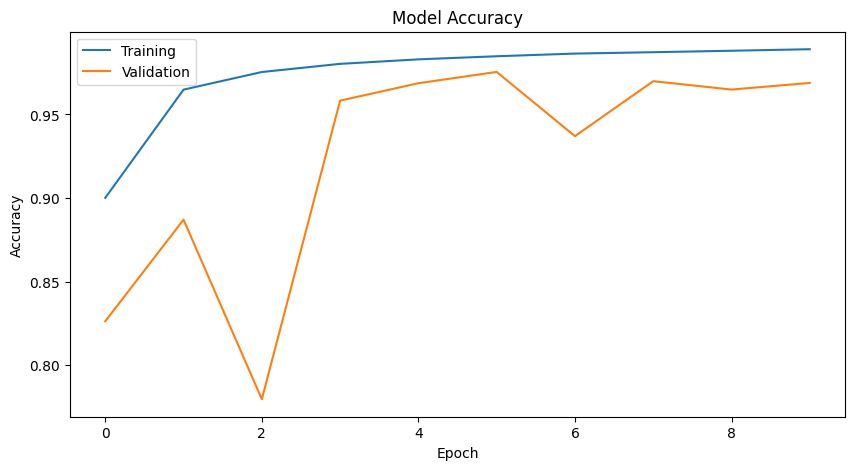

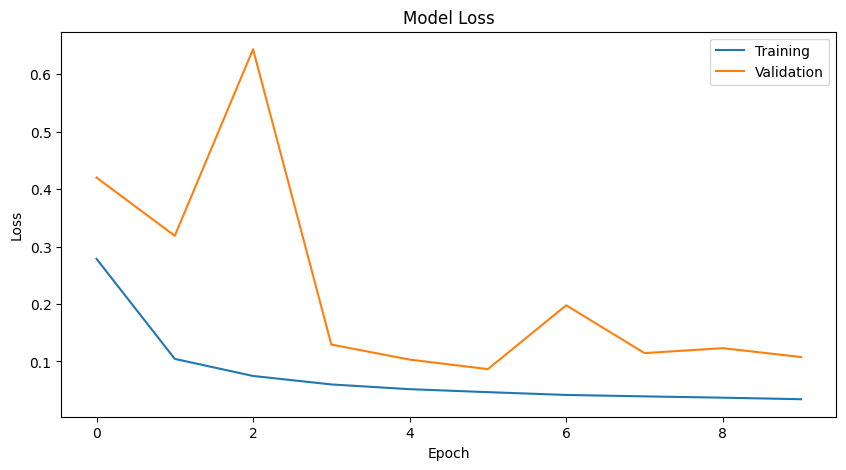

685/685 [==============================] - 7s 9ms/step


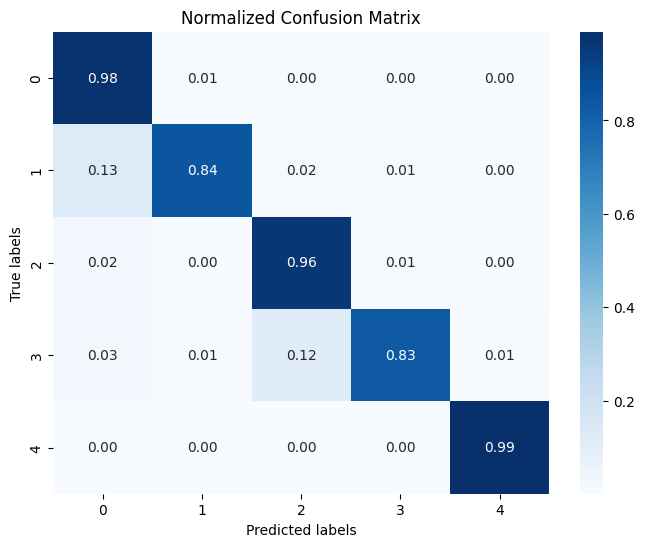

685/685 [==============================] - 6s 9ms/step


In [ ]:
gru_evaluate_model(history,X_test,y_test,model)
y_pred=model.predict(X_test)